In [227]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

In [228]:
# Load COVID-19 case data
# TODO: download most recent data
raw = pd.read_csv('05-05-2020.csv')

# Drop unnecessary columns and remove all regions that are not US counties
raw = raw.drop(['FIPS', 'Last_Update', 'Long_'], axis=1)
raw.drop(raw[raw['Country_Region'] != 'US'].index, inplace=True)
raw.dropna(inplace=True)

# Rename columns
raw.rename(columns={'Lat':'Latitude', 'Combined_Key': 'County'},inplace=True)

# Filter out counties with less than min_sample_size
min_sample_size = 5000
raw = raw[raw['Confirmed'] >= min_sample_size]

def update_county_names(x):
    x = x[:-4]
    
    us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'American Samoa': 'AS',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Guam': 'GU',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands':'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'
    }
    
    for a in us_state_abbrev.keys():
        if a in x:
            index = -1 * len(a)
            x = x[:index]
            x = x + us_state_abbrev[a]
    
    return x
    
raw['County'] = raw['County'].apply(update_county_names)

# Set 'County' as index
raw = raw.groupby('County').sum()

raw

,Latitude,Confirmed,Deaths,Recovered,Active
County,,,,,
"Bergen, NJ",40.960109,16460,1261,0,15199
"Broward, FL",26.151847,5492,215,0,5277
"Cook, IL",41.841448,45223,1922,0,43301
"District of Columbia, DC",38.904178,5322,264,0,5058
"Essex, MA",42.668763,9979,527,0,9452
"Essex, NJ",40.786813,14840,1319,0,13521
"Fairfield, CT",41.268099,12360,935,0,11425
"Harris, TX",29.860000,7128,144,0,6984
"Hartford, CT",41.802830,6351,804,0,5547


In [229]:
# Load county geographical data
def load_geo_data(file, dropCols, indexCol):
    df = pd.read_csv(file)
    df.drop(dropCols, axis=1, inplace=True)
    df.dropna(inplace=True)
    df[indexCol] = df[indexCol].apply(lambda x: x.replace(' County', ''))
    df.set_index(indexCol, drop=True, inplace=True)
    
    return df

# Load temperature data
temp = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011).csv', 
                     ['County Code', 'Avg Daily Max Air Temperature (C)', 'Avg Daily Min Air Temperature (C)'], 'County')
temp

# Load heat index data
# Heat index = "how hot it really feels when relative humidity is factored in with the actual air temperature"
heat_index = load_geo_data('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011)-2.csv',
                           ['County Code'], 'County')
heat_index = heat_index[heat_index['Avg Max Heat Index (C)'] != 'Missing']
heat_index['Avg Max Heat Index (C)'] = heat_index['Avg Max Heat Index (C)'].apply(lambda x: float(x))
heat_index

,Avg Max Heat Index (C)
County,
"Autauga, AL",34.74
"Baldwin, AL",34.77
"Barbour, AL",34.58
"Bibb, AL",34.81
"Blount, AL",34.11
...,...
"Sweetwater, WY",27.14
"Teton, WY",26.47
"Uinta, WY",26.97


In [230]:
# Calculate death rate for each country
def cal_death_rate(total_deaths, total_confirmed):
    death_rate = pd.Series(dtype = float)
    
    # Calculating death rate
    if (total_deaths.index == total_confirmed.index).all():
        death_rate = total_deaths/(total_confirmed + total_deaths)
    else:
        print('Whoops, looks like your countries dont match')
    
    # Drop countries that have a null death rate (don't have any cases)
    death_rate.dropna(inplace=True)
    
    death_rate = pd.DataFrame(death_rate)
    death_rate.rename(columns={death_rate.columns[0]:'Death Rate'},inplace=True)
    
    return death_rate

# Get most recent numbers for comfirmed and deaths
total_confirmed = raw['Confirmed']
total_deaths = raw['Deaths']

# Calculate death rate
death_rate = cal_death_rate(total_deaths, total_confirmed)

death_rate

,Death Rate
County,
"Bergen, NJ",0.071159
"Broward, FL",0.037673
"Cook, IL",0.040768
"District of Columbia, DC",0.047261
"Essex, MA",0.050162
"Essex, NJ",0.081626
"Fairfield, CT",0.070327
"Harris, TX",0.019802
"Hartford, CT",0.112369


In [231]:
# Merge two data sets
def merge_data1(covid_data, geo_data):
    df = geo_data.merge(covid_data, left_index=True, right_index=True)
    
    # Check missing countries
    print(f'We lost {covid_data.shape[0] - df.shape[0]} counties in our merge')
    
    return df
    

def merge_data2(covid_data, raw):
    df = pd.concat([raw, covid_data], axis=1)
    df = df.drop(['Confirmed', 'Deaths', 'Recovered', 'Active'], axis=1)
    return df

# Death rates and latitude
death_and_lat = merge_data2(death_rate, raw)
death_and_lat.describe()

# Death rates and temperature
death_and_temp = merge_data1(death_rate, temp)
death_and_temp

# Death rates and head index
death_and_heatindex = merge_data1(death_rate, heat_index)
death_and_heatindex

We lost 4 counties in our merge
We lost 4 counties in our merge


,Avg Max Heat Index (C),Death Rate
County,,
"Los Angeles, CA",30.51,0.045110
"Fairfield, CT",31.51,0.070327
"Hartford, CT",31.60,0.112369
"New Haven, CT",31.39,0.068179
"District of Columbia, DC",32.65,0.047261
"Broward, FL",34.45,0.037673
"Cook, IL",33.03,0.040768
"Marion, IN",33.14,0.055057
"Montgomery, MD",32.12,0.054598


In [232]:
# Plot linear regression
def lin_regress(merged_data, col_death, col_data, start, line_length):
    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_data[col_data], merged_data[col_death])
    predictions = np.linspace(start,line_length,5) * slope + intercept
    
    # Visualize using plt
    plt.scatter(merged_data[col_data], merged_data[col_death])
    plt.ylabel(col_death)
    plt.xlabel(col_data)
    plt.title(f'{col_death} vs {col_data}')
    plt.plot(np.linspace(start,line_length,5), predictions)
    plt.show()
    
    # Print important values
    print(f'p-values: {p_value}')
    print(f'R^2: {r_value*r_value}')
    print(f'Slope: {slope}')

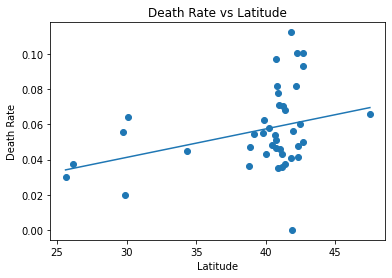

p-values: 0.03688776035823032
R^2: 0.10694645418978166
Slope: 0.0016183989222999038


In [233]:
lin_regress(death_and_lat, 'Death Rate', 'Latitude', death_and_lat['Latitude'].min(), death_and_lat['Latitude'].max())

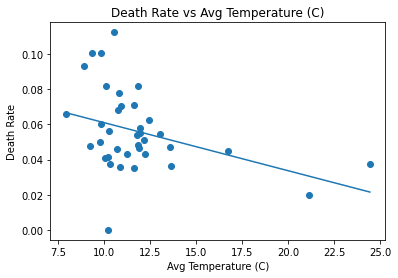

p-values: 0.02270903985908932
R^2: 0.1396446930508946
Slope: -0.002731496192405999


In [234]:
lin_regress(death_and_temp, 'Death Rate', 'Avg Temperature (C)', death_and_temp['Avg Temperature (C)'].min(), death_and_temp['Avg Temperature (C)'].max())

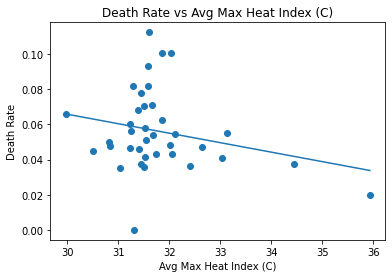

p-values: 0.14355563056831558
R^2: 0.060118230230872
Slope: -0.005396814729671787


In [235]:
lin_regress(death_and_heatindex, 'Death Rate', 'Avg Max Heat Index (C)', death_and_heatindex['Avg Max Heat Index (C)'].min(), death_and_heatindex['Avg Max Heat Index (C)'].max())